Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [10]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [11]:
    from google.colab import drive
    drive.mount('/content/gdrive')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [12]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [13]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2256
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
class_names1=np.array([item.name for item in data_dir.glob('Train/*')])
class_names1

array(['dermatofibroma', 'seborrheic keratosis', 'vascular lesion',
       'nevus', 'melanoma', 'basal cell carcinoma',
       'squamous cell carcinoma', 'pigmented benign keratosis',
       'actinic keratosis'], dtype='<U26')

In [16]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 2256 files belonging to 9 classes.
Using 1805 files for training.


In [17]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 2256 files belonging to 9 classes.
Using 451 files for validation.


In [18]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [19]:
image_generator=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen=image_generator.flow_from_directory(directory=data_dir_train,batch_size=batch_size,
                                                   shuffle=True,target_size=(img_height,img_width),classes=list(class_names))

Found 2256 images belonging to 9 classes.


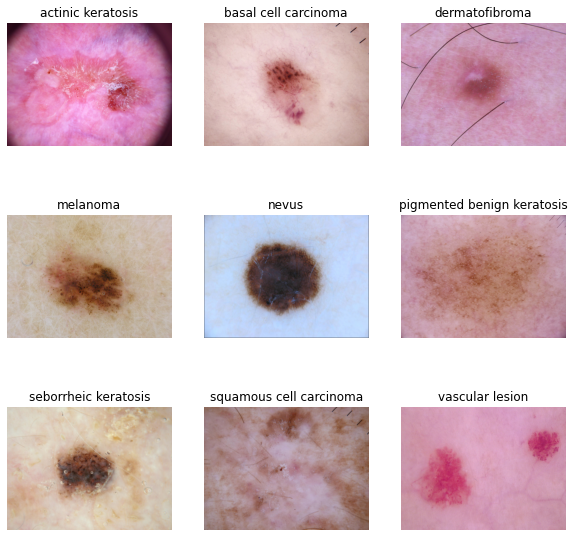

In [20]:
### lets visualize the code 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for index,name in enumerate(class_names):
   ax=plt.subplot(3,3,index+1)
   images=list(data_dir_train.glob(name+'/*'))
   img=mpimg.imread((str(images[0])))
   plt.imshow(img)
   plt.title(name)
   plt.axis('off')


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [22]:
### Lets train the model 
num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [23]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [25]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


57/57 [==============================] - 513s 2s/step - loss: 2.1194 - accuracy: 0.2604 - val_loss: 1.9410 - val_accuracy: 0.2616
Epoch 2/30
57/57 [==============================] - 2s 43ms/step - loss: 1.7484 - accuracy: 0.3640 - val_loss: 1.6606 - val_accuracy: 0.4124
Epoch 3/30
57/57 [==============================] - 2s 41ms/step - loss: 1.5816 - accuracy: 0.4515 - val_loss: 1.5643 - val_accuracy: 0.4302
Epoch 4/30
57/57 [==============================] - 2s 42ms/step - loss: 1.3949 - accuracy: 0.5091 - val_loss: 1.4255 - val_accuracy: 0.4989
Epoch 5/30
57/57 [==============================] - 2s 41ms/step - loss: 1.2944 - accuracy: 0.5535 - val_loss: 1.4233 - val_accuracy: 0.4701
Epoch 6/30
57/57 [==============================] - 2s 42ms/step - loss: 1.2463 - accuracy: 0.5684 - val_loss: 1.3972 - val_accuracy: 0.5078
Epoch 7/30
57/57 [==============================] - 2s 41ms/step - loss: 1.1560 - accuracy: 0.5950 - val_loss: 1.3182 - val_accuracy: 0.5144
Epoch 8/30
57/57 [======

### Visualizing training results

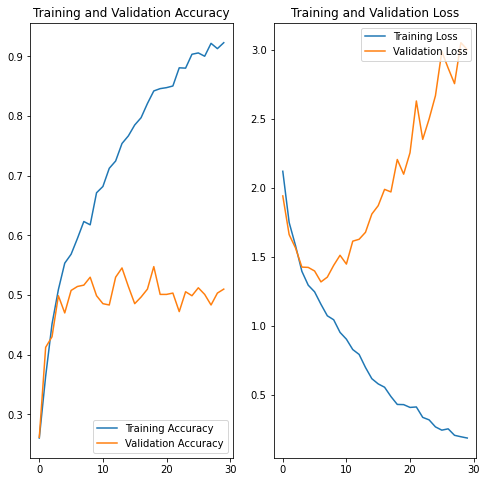

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

By Observing the above grapgh, i see train and validation accuracy away from each other, which is a clear sign of overfitting

In [27]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

In [28]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Data Augmentation
augmented_data=keras.Sequential([
                                    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
                                    layers.experimental.preprocessing.RandomRotation(0.1),
                                    layers.experimental.preprocessing.RandomZoom(0.1)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


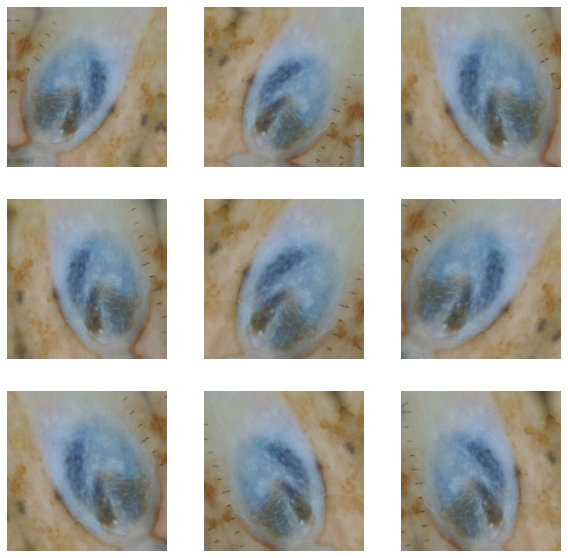

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(7):
  for i in range(9):
    augmented_images = augmented_data(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model = Sequential([
  augmented_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.25),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compiling the model

In [31]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
dropout (Dropout)            (None, 180, 180, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)       

### Training the model

In [33]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


57/57 [==============================] - 8s 113ms/step - loss: 1.9888 - accuracy: 0.2432 - val_loss: 1.8664 - val_accuracy: 0.3304
Epoch 2/30
57/57 [==============================] - 6s 101ms/step - loss: 1.7269 - accuracy: 0.3806 - val_loss: 1.6727 - val_accuracy: 0.3925
Epoch 3/30
57/57 [==============================] - 6s 102ms/step - loss: 1.5451 - accuracy: 0.4676 - val_loss: 1.4954 - val_accuracy: 0.4435
Epoch 4/30
57/57 [==============================] - 6s 101ms/step - loss: 1.5211 - accuracy: 0.4687 - val_loss: 1.6004 - val_accuracy: 0.4213
Epoch 5/30
57/57 [==============================] - 6s 101ms/step - loss: 1.4407 - accuracy: 0.4920 - val_loss: 1.4315 - val_accuracy: 0.5033
Epoch 6/30
57/57 [==============================] - 6s 101ms/step - loss: 1.3824 - accuracy: 0.5125 - val_loss: 1.4167 - val_accuracy: 0.4856
Epoch 7/30
57/57 [==============================] - 6s 102ms/step - loss: 1.3589 - accuracy: 0.5130 - val_loss: 1.4056 - val_accuracy: 0.4834
Epoch 8/30
57/57 

### Visualizing the results

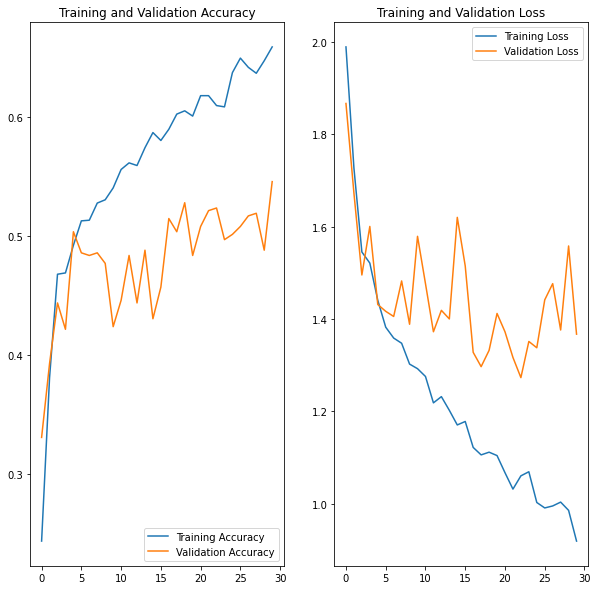

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [35]:
from sklearn.datasets import load_files 
from keras.utils import np_utils
def load_data_raw (path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 9)
    
    return files, targets

train_filenames, train_targets = load_data_raw(data_dir_train)

<BarContainer object of 9 artists>

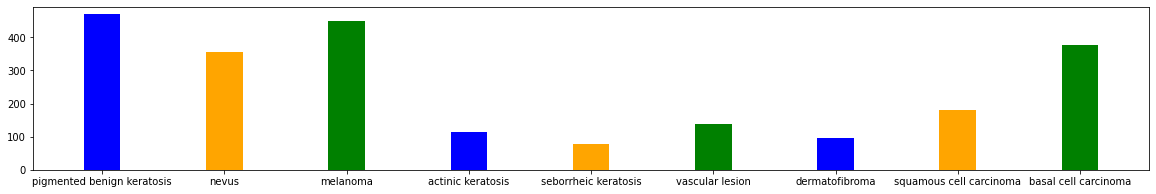

In [36]:
from collections import Counter
filenames_trimmed = [filename.split('/')[-2] for filename in train_filenames]
classes_count = Counter(filenames_trimmed)

# Plot the classes
plt.figure(figsize=(20, 3))
plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'],width=0.3)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
path_to_training_dataset="/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/skin_db/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAD8C668A50>: 100%|██████████| 500/500 [00:22<00:00, 22.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/skin_db/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAD86D43B50>: 100%|██████████| 500/500 [00:22<00:00, 21.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/skin_db/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FADEA374990>: 100%|██████████| 500/500 [00:23<00:00, 21.56 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/drive/MyDrive/skin_db/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAD8BF6AE90>: 100%|██████████| 500/500 [01:39<00:00,  5.03 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/skin_db/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FADEA37E450>: 100%|██████████| 500/500 [01:33<00:00,  5.35 Samples/s]


Initialised with 469 image(s) found.
Output directory set to /content/drive/MyDrive/skin_db/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FADE9EA33D0>: 100%|██████████| 500/500 [00:23<00:00, 21.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/skin_db/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FADE9D3E7D0>: 100%|██████████| 500/500 [00:49<00:00, 10.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/skin_db/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FADEA37AAD0>: 100%|██████████| 500/500 [00:22<00:00, 21.99 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/skin_db/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FADEA386F90>: 100%|██████████| 500/500 [00:21<00:00, 22.75 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)
print(path_list_new)

['/content/drive/MyDrive/skin_db/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_066c2535-7f5f-4db3-8881-ed57bbe5b64d.jpg', '/content/drive/MyDrive/skin_db/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030427.jpg_a52f6cf7-ba95-404a-ab53-12c99ec618f3.jpg', '/content/drive/MyDrive/skin_db/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027648.jpg_13fca7f8-96e2-406a-97d6-97d074136062.jpg', '/content/drive/MyDrive/skin_db/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031443.jpg_fad53746-fa63-4279-b43b-dcf1d7f67951.jpg', '/content/drive/MyDrive/skin_db/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029052.jpg_1b8aa54b-28f7-4d3b-96a0-c19bb06dfdd2.jpg', '/content/drive/MyDrive/skin_db/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_16389864-ad50-497f-a4d5-edf0a6ee241b.jpg', '/content/drive/MyDrive/skin_db/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033554.jpg_427d02df-eb55-4379-9973-57296c91aa

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(lesion_list_new))
print(lesion_list_new)

4500
['dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'dermatofibroma', 'der

In [42]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [43]:
path_list=[x for x in glob.glob(os.path.join(data_dir_train,'*','*.jpg'))]
len(path_list)

2256

In [44]:
lesion_list= [i.split('/')[-2] for i in path_list]
len(lesion_list)

2256

In [45]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [46]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [47]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [48]:
new_df = original_df.append(df2)

In [49]:
new_df['Label'].value_counts()

pigmented benign keratosis    969
melanoma                      948
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [50]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [51]:
data_dir_train="/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 6756 files belonging to 9 classes.
Using 5405 files for training.


#### **Todo:** Create a validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 6756 files belonging to 9 classes.
Using 1351 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [53]:
## your code goes here
model = Sequential([
  augmented_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.25),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [54]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
dropout_2 (Dropout)          (None, 180, 180, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)       

#### **Todo:**  Train your model

In [56]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 42s 234ms/step - loss: 1.9408 - accuracy: 0.2575 - val_loss: 1.7212 - val_accuracy: 0.3486
Epoch 2/50
169/169 [==============================] - 40s 228ms/step - loss: 1.6473 - accuracy: 0.3582 - val_loss: 1.5706 - val_accuracy: 0.3879
Epoch 3/50
169/169 [==============================] - 39s 224ms/step - loss: 1.5167 - accuracy: 0.4144 - val_loss: 1.3915 - val_accuracy: 0.4856
Epoch 4/50
169/169 [==============================] - 39s 225ms/step - loss: 1.3768 - accuracy: 0.4809 - val_loss: 1.4122 - val_accuracy: 0.4796
Epoch 5/50
169/169 [==============================] - 39s 223ms/step - loss: 1.3287 - accuracy: 0.4910 - val_loss: 1.3450 - val_accuracy: 0.5144
Epoch 6/50
169/169 [==============================] - 39s 221ms/step - loss: 1.3150 - accuracy: 0.4997 - val_loss: 1.3982 - val_accuracy: 0.4796
Epoch 7/50
169/169 [==============================] - 39s 223ms/step - loss: 1.2330 - accuracy: 0.5288 - val_loss: 1.2551 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

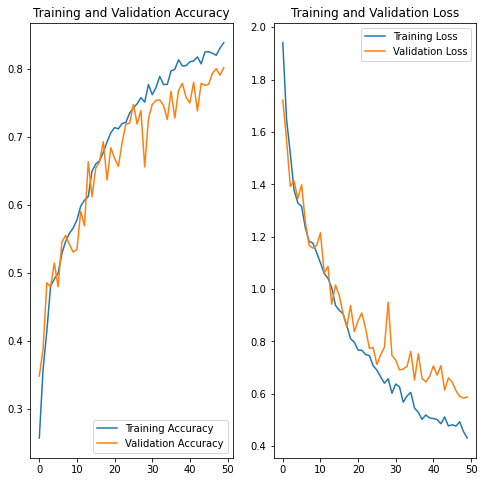

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes
